In [1]:
import cheetah
from typing import Dict, Optional
import torch
import torch.nn as nn
from xopt import VOCS
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize, LogNorm
from bo_cheetah_prior import simple_fodo_problem
import seaborn as sns
import pandas as pd

In [2]:
# Plotting Styles

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "axes.titlesize": 10,
        "axes.labelsize": 10,
        "legend.fontsize": 8,
    }
)
inches_per_pt = 1.0/72.27  
line_width = 214.7352
fig_width = line_width*inches_per_pt

In [3]:
# Load Data
df_nm = pd.read_csv("data/NM_matched.csv")
df_nm_mismatched = pd.read_csv("data/NM_mismatched.csv")
df_bo_matched = pd.read_csv("data/BO_matched.csv")
df_bo_mismatched = pd.read_csv("data/BO_mismatched.csv")
df_bo_prior_matched = pd.read_csv("data/BO_prior_matched.csv")
df_bo_prior_mismatched = pd.read_csv("data/BO_prior_mismatched.csv")

## Grid Scan for true minimum

In [4]:
# Grid Scan to get the true minimum (for both matched and mismatched)
vocs_config = """ 
    variables:
        q1: [-30, 15]
        q2: [-15, 30]
    objectives:
        mae: minimize
"""
vocs = VOCS.from_yaml(vocs_config)
n_points = 50
xs = np.linspace(vocs.variables["q1"][0], vocs.variables["q1"][1], n_points, dtype=np.float32)
ys = np.linspace(vocs.variables["q2"][0], vocs.variables["q2"][1], n_points, dtype=np.float32)

X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)
Z_mismatched = np.zeros_like(X)
for i in range(n_points):
    for j in range(n_points):
        Z[i, j] = simple_fodo_problem(
            {
                "q1": X[i, j],
                "q2": Y[i, j],
            }
        )["mae"]
        Z_mismatched[i, j] = simple_fodo_problem(
            {
                "q1": X[i, j],
                "q2": Y[i, j],
            },
            lattice_distances={
                "drift_length": 0.7,
            }
        )["mae"]


In [5]:
min_idx_original = np.unravel_index(np.argmin(Z), Z.shape)
min_idx_mismatched = np.unravel_index(np.argmin(Z_mismatched), Z_mismatched.shape)
best_original_in_mismatched = simple_fodo_problem(
            {
                "q1": float(X[min_idx_original]),
                "q2": float(Y[min_idx_original]),
            }, 
            # incoming_beam=mismatched_incoming_beam, 
            lattice_distances={
                "drift_length": 0.7,
            }
        )
print(best_original_in_mismatched)

{'mse': array(1.5546661e-06, dtype=float32), 'log_mse': array(-13.374249, dtype=float32), 'mae': array(0.00092902, dtype=float32), 'log_mae': array(-6.981385, dtype=float32)}


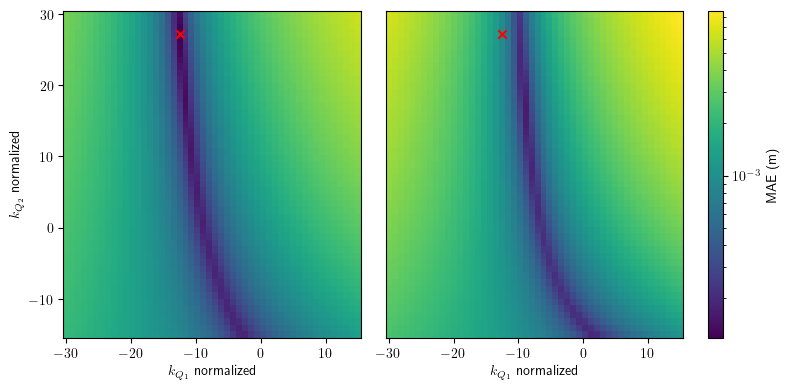

In [6]:
# plt.contourf(X, Y, Z)
fig, axes = plt.subplots(1, 3, figsize=(8, 4), gridspec_kw={"width_ratios": [1, 1, 0.05]})
vmin = np.min([Z.min(), Z_mismatched.min()])
vmax = np.max([Z.max(), Z_mismatched.max()])
# color_norm = Normalize(vmin=vmin, vmax=vmax)
color_norm = LogNorm(vmin=vmin, vmax=vmax)
cbar = axes[0].pcolormesh(X, Y, Z, norm=color_norm)
axes[1].pcolormesh(X, Y, Z_mismatched, norm=color_norm)
axes[0].set_ylabel(r"$k_{Q_2}$ normalized")
axes[1].set_xlabel(r"$k_{Q_1}$ normalized")
axes[1].set_yticks([])
axes[0].scatter(X[min_idx_original], Y[min_idx_original], marker="x", color="red")
axes[1].scatter(X[min_idx_original], Y[min_idx_original], marker="x", color="red")
for ax in axes[:2]:
    ax.set_xlabel(r"$k_{Q_1}$ normalized")
    # ax.set_xticks([-30, 15])
    # ax.set_xticklabels([0,1])

plt.colorbar(cbar, cax=axes[2], label="MAE (m)")
fig.tight_layout()

## Final Plot

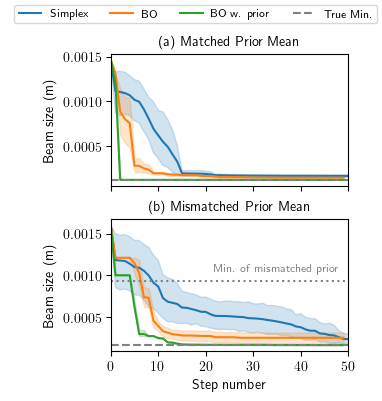

In [12]:
# 
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(fig_width, fig_width*1.3), sharex=True)

# Matched Case
sns.lineplot(data=df_nm, x="step", y="best_mae", ax=ax1, label="Simplex")
sns.lineplot(data=df_bo_matched, x="step", y="best_mae", ax=ax1, label="BO")
sns.lineplot(data=df_bo_prior_matched, x="step", y="best_mae", ax=ax1, label="BO w. prior")
ax1.axhline(y=Z.min(), color="grey", linestyle="--", label="True Min.")

# Mis-matched Case
sns.lineplot(data=df_nm_mismatched, x="step", y="best_mae", ax=ax2, label="Simplex")
sns.lineplot(data=df_bo_mismatched, x="step", y="best_mae", ax=ax2, label="BO")
sns.lineplot(data=df_bo_prior_mismatched, x="step", y="best_mae", ax=ax2, label="BO w. prior")
ax2.axhline(y=best_original_in_mismatched["mae"], color="grey", linestyle=":", label="Mismatched Min.")
ax2.axhline(y=Z_mismatched.min(), color="grey", linestyle="--", label="True Min.")
ax2.text(0.7, 0.6, "Min. of mismatched prior", transform=ax2.transAxes, color="grey", ha="center", fontdict={"size": 8})

ax1.set_title("(a) Matched Prior Mean")
ax2.set_title("(b) Mismatched Prior Mean")

for ax in [ax1, ax2]:
    ax.set_ylabel("Beam size (m)")
    ax.set_xlim(0, 50)
    ax.get_legend().remove()
ax2.set_xlabel("Step number")

# align y label
fig.align_ylabels()
handles, labels = ax1.get_legend_handles_labels()
# Plot the legend vertically on the right side of the plot
fig.legend(handles, labels, loc='upper right', ncols=4)
fig.subplots_adjust(top=0.87, bottom=0.1, left=0.1, right=0.9, hspace=0.25)
fig.savefig("../figures/bo_cheetah_prior_result.pdf", bbox_inches="tight")